# Softmax  分类器


This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


- 实现Softmax分类器的全向量化损失函数
- 实现其分解梯度的完全向量化表达式
- 用数值梯度检查你的实现
- 使用验证集调整学习率和正则化强度
- 用SGD优化损耗功能
- 可视化最终学习的权重

In [1]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function # 把下一个新版本的特性导入到当前版本，就可以在当前版本中测试一些新版本的特性

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置 size
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# notebook 会 reload外部python modules
%load_ext autoreload 
%autoreload 2

## 数据集

#### get data and preprocessing

In [3]:
def get_CIFAR_10_data(num_train = 49000,num_val = 1000,num_test = 10000,num_dev = 500):
    # 1、Load the raw CIFAR-10 data.
    cifar10_dir = 'datasets/cifar-10-batches-py/'
    X_train, y_train,  X_test, y_test = load_CIFAR10(cifar10_dir)

    # 2、subsample the data
    # validation set
    mask = list(range(num_train, num_train + num_val)) 
    X_val = X_train[mask]
    y_val = y_train[mask]

    # training set 
    mask = list(range(num_train))  
    X_train = X_train[mask]
    y_train = y_train[mask]

    # test set   
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # development set
    mask = np.random.choice(num_train, num_dev, replace=False) 
    X_dev = X_train[mask]
    y_dev = y_train[mask]


    # 3、proprocessing --reshape: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1)) 
    X_val = np.reshape(X_val, (X_val.shape[0], -1)) 
    X_test = np.reshape(X_test, (X_test.shape[0], -1)) 
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1)) 


    # 4、proprocessing -- 归一化: subtract the mean image 减去 图像均值
    #  4.1、计算 train data 的均值图像
    mean_img = np.mean(X_train, axis=0)

    #  4.2、 train 和 test data 减去 均值图像
    X_train -= mean_img
    X_val -= mean_img
    X_test -= mean_img
    X_dev -= mean_img

    # 5、proprocessing -- 加入 bias: 每个 image 增加 1维的 bias
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) 
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) 
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))]) 
    
    return X_train,y_train,X_val,y_val, X_test, y_test, X_dev,y_dev

In [4]:
# get data and cheak it
X_train,y_train,X_val,y_val, X_test, y_test, X_dev,y_dev = get_CIFAR_10_data()
print ('X_train shape:  ',X_train.shape)
print ('y_train shape:  ',y_train.shape)
print ('X_val shape:    ',X_val.shape)
print ('y_val shape:    ',y_val.shape)
print ('X_test shape:   ',X_test.shape)
print ('y_test shape:   ',y_test.shape)
print ('X_dev shape:    ',X_dev.shape)
print ('y_dev shape:    ',y_dev.shape)

X_train shape:   (49000, 3073)
y_train shape:   (49000,)
X_val shape:     (1000, 3073)
y_val shape:     (1000,)
X_test shape:    (10000, 3073)
y_test shape:    (10000,)
X_dev shape:     (500, 3073)
y_dev shape:     (500,)


## Softmax Classifier

#### 创建分类器

In [63]:
from classifiers.softmax import softmax_loss_naive
from classifiers.softmax import softmax_loss_vectorized
import time

In [54]:
# 检查 code 能否运行成功
# 使用很小的值 随机 初始化W
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

print ('loss: %f' %(loss, ))
print (grad[1])

# As a rough sanity check, our loss should be something close to -log(0.1).
print ('check:%f' % (-np.log(0.1)))

loss: 2.368848
[-11.67146122  28.20780816 -17.62963469  19.78780816  19.47        33.35219184
   0.78926939  -4.92671224 -31.12817347 -36.25109592]
check:2.302585


In [55]:
# 检查 code 能否运行成功
# 使用很小的值 随机 初始化W
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

print ('loss: %f' %(loss, ))
print (grad[1])

# As a rough sanity check, our loss should be something close to -log(0.1).
print ('check:%f' % (-np.log(0.1)))

here
loss: 2.360925
[-2.59387582  2.8389124  -3.32623315  2.85494143  1.39678275  4.195417
  0.8924992   0.57720118 -1.78679612 -5.04884886]
check:2.302585


#### 梯度检查
- 梯度检查：分析梯度的结果 与 数值梯度结果 进行比较

In [52]:
from gradient_check import grad_check_sparse

# 1、 损失函数 不加入 正则化损失时，进行 梯度检查
print ("without  regularation")
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


# 2、 损失函数 加入 正则化损失时，进行 梯度检查
print ("with  regularation")
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

without  regularation
numerical: -1.348592 analytic: -5.157154, relative error: 5.854152e-01
numerical: -0.363955 analytic: 0.667385, relative error: 1.000000e+00
numerical: -0.989875 analytic: 0.664187, relative error: 1.000000e+00
numerical: -0.848655 analytic: -1.787335, relative error: 3.561018e-01
numerical: -1.336255 analytic: -11.535037, relative error: 7.923666e-01
numerical: 1.644652 analytic: 20.453900, relative error: 8.511530e-01
numerical: -0.017991 analytic: 0.680093, relative error: 1.000000e+00
numerical: 0.516889 analytic: 7.750692, relative error: 8.749601e-01
numerical: 0.660750 analytic: -2.524000, relative error: 1.000000e+00
numerical: 1.888168 analytic: 9.830000, relative error: 6.777366e-01
with  regularation
numerical: 0.780736 analytic: 15.743064, relative error: 9.055016e-01
numerical: -0.064771 analytic: -8.140000, relative error: 9.842114e-01
numerical: -5.309739 analytic: -45.467771, relative error: 7.908626e-01
numerical: 1.435399 analytic: 15.516543, rel

#### 比较 不同方法计算loss + grad的运行时间，以及loss 的差距

In [56]:
# 用 naive 方法计算的 loss + grad 时的运行时间
start = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 5e1)
end = time.time()
print ("Naive loss : %e computer in %fs" %(loss_naive, end - start))

# 用 vectorized 方法计算的 loss + grad 时的运行时间
start = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 5e1)
end = time.time()
print ("Vectorized loss : %e computer in %fs" %(loss_vectorized, end - start))


# 比较 两个loss 的差距
loss_different = loss_naive - loss_vectorized  # loss 是 single number
print ('loss_different: %f' % (loss_different))


# 比较 两个gradient 的差距 -- math:`||A||_F = [\sum_{i,j} abs(a_{i,j})^2]^{1/2}`
grad_different = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')  # 梯度是 matrix
print ('grad_different: %f' % (grad_different))

Naive loss : 2.401513e+00 computer in 0.134876s
here
Vectorized loss : 2.360925e+00 computer in 0.013941s
loss_different: 0.040588
grad_different: 2845.720951


## 调整超参数 --> 交叉验证  on  val set 
- 在 train set 上训练 分类器,获取loss
- 在 train set 和 val set 上 计算 准确率

In [68]:
from classifiers.linear_classifier import LinearSoftmax

# 设置 需要调整的参数 及其 范围
learning_rate = [1e-7, 5e-5, 4e-3]
regularization_strength = [2.5e4, 5e4, 8e4]

results = {} #(learning_rate, regularization_strength)
best_val = -1
best_softmax = None

num_iters = 10
for lr in learning_rate:
    for reg in regularization_strength:
        print ("\n ======>>>> lr : reg --> ",lr ,'--', reg)
        
        # 1、创建 分类器
        softmax = LinearSoftmax()
        
        # 2、训练 分类器
        loss_history = softmax.train(X_train, y_train,
                                    learning_rate=lr, 
                                    reg=reg,
                                    num_iters=num_iters, 
                                    batch_size=256, 
                                    verbose=True)
        
        # 3、计算 准确率
        train_pred = softmax.predict(X_train)
        train_acc = np.mean( y_train == train_pred)
        
        val_pred = softmax.predict(X_val)
        val_acc = np.mean( y_val == val_pred)
        
        # 4、存储 结果 
        results[(lr, reg)] = (train_acc,val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax


 ======>>>> lr : reg -->  1e-07 -- 25000.0
iteration 0 / 10: loss 775.219256
iteration 1 / 10: loss 775.009923
iteration 2 / 10: loss 775.196286
iteration 3 / 10: loss 774.913710
iteration 4 / 10: loss 774.702482
iteration 5 / 10: loss 774.878825
iteration 6 / 10: loss 774.871425
iteration 7 / 10: loss 774.787658
iteration 8 / 10: loss 774.898343
iteration 9 / 10: loss 774.721180

 ======>>>> lr : reg -->  1e-07 -- 50000.0
iteration 0 / 10: loss 1552.399853
iteration 1 / 10: loss 1552.583665
iteration 2 / 10: loss 1552.330924
iteration 3 / 10: loss 1552.313135
iteration 4 / 10: loss 1552.043716
iteration 5 / 10: loss 1552.048318
iteration 6 / 10: loss 1551.906045
iteration 7 / 10: loss 1551.720460
iteration 8 / 10: loss 1551.625294
iteration 9 / 10: loss 1551.687764

 ======>>>> lr : reg -->  1e-07 -- 80000.0
iteration 0 / 10: loss 2416.751122
iteration 1 / 10: loss 2416.430797
iteration 2 / 10: loss 2415.945106
iteration 3 / 10: loss 2416.233419
iteration 4 / 10: loss 2416.389735
ite

d:\DL_sum\cs231n\test_1_3_softmax\classifiers\softmax.py:94: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
d:\DL_sum\cs231n\test_1_3_softmax\classifiers\softmax.py:100: RuntimeWarning: invalid value encountered in multiply
  sum_scores = 1.0 / sum_scores
d:\DL_sum\cs231n\test_1_3_softmax\classifiers\softmax.py:105: RuntimeWarning: divide by zero encountered in log
  


iteration 1 / 10: loss nan
iteration 2 / 10: loss nan
iteration 3 / 10: loss nan
iteration 4 / 10: loss nan
iteration 5 / 10: loss nan
iteration 6 / 10: loss nan
iteration 7 / 10: loss nan
iteration 8 / 10: loss nan
iteration 9 / 10: loss nan

 ======>>>> lr : reg -->  0.004 -- 50000.0
iteration 0 / 10: loss 1533.742336
iteration 1 / 10: loss nan
iteration 2 / 10: loss nan
iteration 3 / 10: loss nan
iteration 4 / 10: loss nan
iteration 5 / 10: loss nan
iteration 6 / 10: loss nan
iteration 7 / 10: loss nan
iteration 8 / 10: loss nan
iteration 9 / 10: loss nan

 ======>>>> lr : reg -->  0.004 -- 80000.0
iteration 0 / 10: loss 2479.133671
iteration 1 / 10: loss nan
iteration 2 / 10: loss nan
iteration 3 / 10: loss nan
iteration 4 / 10: loss nan
iteration 5 / 10: loss nan
iteration 6 / 10: loss nan
iteration 7 / 10: loss nan
iteration 8 / 10: loss nan
iteration 9 / 10: loss nan


In [69]:
# 打印 cross-validation results
for lr, reg in sorted(results):
    train_acc, val_acc = results[(lr, reg)]
    print ('lr:%e  reg:%e  --> train accuracy:%f ; val accuracy:%f ' % (
          lr, reg, train_acc, val_acc) )
print ('Best validation accuracy achieved during cross-validation: %f' % best_val)


lr:1.000000e-07  reg:2.500000e+04  --> train accuracy:0.108265 ; val accuracy:0.105000 
lr:1.000000e-07  reg:5.000000e+04  --> train accuracy:0.092449 ; val accuracy:0.097000 
lr:1.000000e-07  reg:8.000000e+04  --> train accuracy:0.125490 ; val accuracy:0.114000 
lr:5.000000e-05  reg:2.500000e+04  --> train accuracy:0.174510 ; val accuracy:0.167000 
lr:5.000000e-05  reg:5.000000e+04  --> train accuracy:0.226367 ; val accuracy:0.245000 
lr:5.000000e-05  reg:8.000000e+04  --> train accuracy:0.255796 ; val accuracy:0.261000 
lr:4.000000e-03  reg:2.500000e+04  --> train accuracy:0.100265 ; val accuracy:0.087000 
lr:4.000000e-03  reg:5.000000e+04  --> train accuracy:0.100265 ; val accuracy:0.087000 
lr:4.000000e-03  reg:8.000000e+04  --> train accuracy:0.100265 ; val accuracy:0.087000 
Best validation accuracy achieved during cross-validation: 0.261000


#### 可视化  cross-validation results

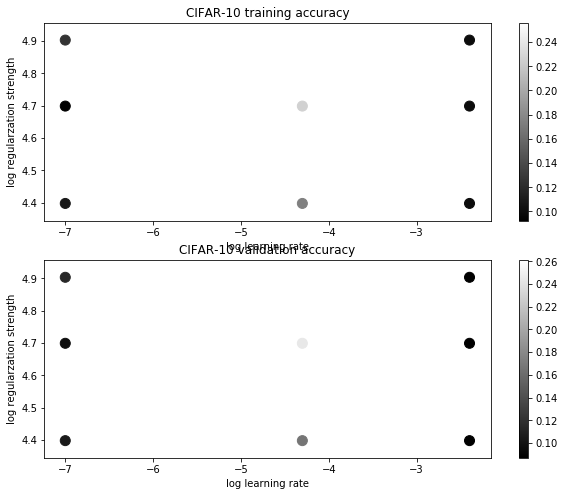

In [70]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
market_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, market_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularzation strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
market_size = 100
colors = [results[x][1] for x in results]
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, market_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularzation strength')
plt.title('CIFAR-10 validation accuracy')

plt.show()

####  可视化 每个类别 W 

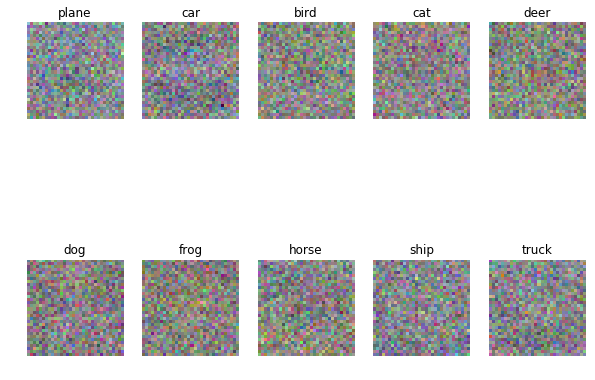

In [71]:
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## test

In [72]:
# 在 test set 上 评估 上述选中的 best_svm 分类器
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.256800
